In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import zipfile

%matplotlib inline

In [2]:
base_data_dir = os.path.abspath('../../_data')
kmnist_data_dir = os.path.join(base_data_dir, 'Kannada-MNIST')
kmnist_zip_file = os.path.join(base_data_dir, 'Kannada-MNIST.zip')

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Download the competiotion datasets

In [68]:
# Downloading dataset
# if not os.path.exists(kmnist_data_dir):
#     ! kaggle competitions download -c Kannada-MNIST -p {base_data_dir}

In [69]:
# Extract the zip file
# if os.path.exists(kmnist_zip_file):
#     with zipfile.ZipFile(file=kmnist_zip_file, mode='r') as z:
#         z.extractall(kmnist_data_dir)

In [70]:
# Delete the downloaded zip file
# if os.path.exists(kmnist_zip_file):
#     ! rm {kmnist_zip_file}

### Load and investigate the data

In [4]:
if os.path.exists(kmnist_data_dir):
    ! ls {kmnist_data_dir}

Dig-MNIST.csv
sample_submission.csv
test.csv
train.csv


In [5]:
train_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/train.csv')
test_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/test.csv')

train_csv.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_csv.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Images are 28x28 pixels, and pixels are flattend and each image saved in a row (total of 784 pixels)**

In [7]:
# Save values of images in numpy.ndarray
trainset = train_csv.iloc[:, 1:].values
labels = train_csv.iloc[:, 0].values
testset = test_csv.iloc[:, 1:].values

print(f'Train set shape: {trainset.shape}')
print(f'Test set shape: {testset.shape}')

Train set shape: (60000, 784)
Test set shape: (5000, 784)


In [8]:
print(f'Min pixel value: {trainset.min()}')
print(f'Max pixel value: {trainset.max()}')

Min pixel value: 0
Max pixel value: 255


In [9]:
def imshow(img, label=None, ax=None):
    img = np.reshape(img, (28, 28))
    fig = plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=plt.cm.Greys)
    if label is not None:
        plt.title(f'Label: {label}')
    plt.show()

In [13]:
def batch_show(images, labels=None, n_images=5):
    images_so_far = 0
    indices = np.random.choice(np.arange(images.shape[0]), n_images)
    
    fig = plt.figure(figsize=(10, 10))
    for i in indices:
        images_so_far += 1
        ax = fig.add_subplot(n_images//2, 3, images_so_far)        
        ax.axis('off')
        if labels is not None:
            ax.set_title(f'Label: {labels[i]}')
        ax.imshow(images[i].reshape(28,28), cmap=plt.cm.Greys)

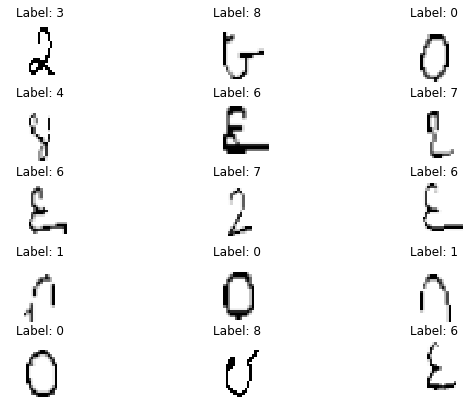

In [15]:
batch_show(trainset, labels, n_images=15)

### Data preprocessing

In [16]:
# reshaping 2D ndarrays into 4D (#images, #channel, #width, #height)
# converting datasets into tensors
trainset = torch.tensor(np.reshape(trainset, (trainset.shape[0], 1, 28, 28))).type(torch.FloatTensor)
labels = torch.tensor(labels).view(labels.shape[0], 1)
testset = torch.tensor(np.reshape(testset, (testset.shape[0], 1, 28, 28))).type(torch.FloatTensor)
trainset.shape, labels.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000, 1]))

In [17]:
# Normalize pixel values
trainset /= 255.0
testset /= 255.0

In [18]:
class KannadaDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img, target = self.images[index], int(self.labels[index])
        return img, target
    
    @property
    def classes(self):
        return torch.unique(labels)
    
    @property
    def c(self):
        return len(torch.unique(labels))

In [19]:
bs = 64

train_dataset = KannadaDataset(trainset, labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

### Designing the Neural Network

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution layer sees (28x28x1 tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        # Convolution layer sees (14x14x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)        
        self.pool = nn.MaxPool2d(2,2)
        # dense layer after last conv and pooling layer
        self.fc1 = nn.Linear(in_features= 7*7*32, out_features=256)
        # output layer
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input        
        x = x.view(-1, 7*7*32)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

In [28]:
model = Net()
model = model.to(device)
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Train the network

In [70]:
model = Net()
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.003)
ephocs = 25

train_losses, train_accs = [], []

for e in range(ephocs):
    model.train()
    run_loss = 0.0
    run_acc = 0.0
    
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        logit = model.forward(images)
        ps = torch.exp(logit)                       # convert log_softmax values to probabilities
        top_p, top_c = torch.max(ps, dim=1)         # get the max probability value and class
        loss = criterion(logit, labels)
        loss.backward()
        optimizer.step()
        
        # check the equality of predicted classes and true labels
        equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)
        
        run_acc += torch.mean(equals).item()
        run_loss += loss.item()        
    else:
        print(f'Epoch {e+1}/{ephocs}:')
        print('-'*50)
        print(f'Training accuracy: {round(run_acc/len(train_dataloader), 5)}')
        print(f'Training loss: {round(run_loss/len(train_dataloader), 5)}\n')

Epoch 1/25:
--------------------------------------------------
Training accuracy: 0.44235
Training loss: 2.17671

Epoch 2/25:
--------------------------------------------------
Training accuracy: 0.85404
Training loss: 0.73696

Epoch 3/25:
--------------------------------------------------
Training accuracy: 0.91714
Training loss: 0.28772

Epoch 4/25:
--------------------------------------------------
Training accuracy: 0.93342
Training loss: 0.22601

Epoch 5/25:
--------------------------------------------------
Training accuracy: 0.94171
Training loss: 0.1979

Epoch 6/25:
--------------------------------------------------
Training accuracy: 0.94573
Training loss: 0.18129

Epoch 7/25:
--------------------------------------------------
Training accuracy: 0.94949
Training loss: 0.16899

Epoch 8/25:
--------------------------------------------------
Training accuracy: 0.95249
Training loss: 0.15815

Epoch 9/25:
--------------------------------------------------
Training accuracy: 0.95514

In [126]:
# save model and optimizer paramaters to disk
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
     }, kmnist_data_dir + '/Saved-Models/stage1_acc-0.9747_loss-0.0832.pth')

### Make Predictions

In [110]:
# set model to evaluation mode
model.eval()
preds = []

for images in test_dataloader:
    images = images.to(device)
    logit = model.forward(images)
    ps = torch.exp(logit)
    top_p, top_c = torch.max(ps, dim=1)
    preds.extend(top_c.to('cpu'))
    
preds = [p.item() for p in preds]

In [111]:
len(preds)

5000

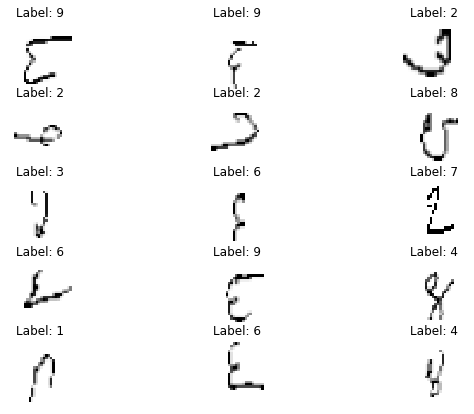

In [123]:
batch_show(testset, preds, n_images=15)

### Save predictions and make submission

In [116]:
sample_submission = pd.read_csv(kmnist_data_dir + '/sample_submission.csv')
sample_submission.head(10)

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
5,5,5
6,6,5
7,7,5
8,8,5
9,9,5


In [119]:
type(test_csv['id'])

pandas.core.series.Series

In [120]:
submission_dict = {
    'id': test_csv['id'],
    'label': preds
}

submission_df = pd.DataFrame(data=submission_dict)
submission_df.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [122]:
submission_df.to_csv(kmnist_data_dir + '/submission.csv', index=False)